In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 加载和准备数据

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### 10天左右用车情况

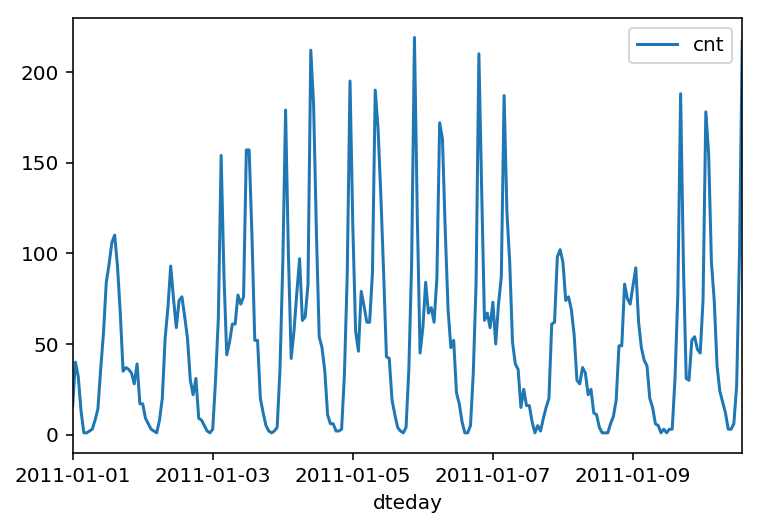

In [3]:
rides[:24*10].plot(x='dteday', y='cnt')

### 虚拟变量
分类变量，如季节、天气、月份等，需创建二进制虚拟变量。用Pandas中的get_dummies()可轻松实现。

In [4]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each,drop_first=False)
    rides = pd.concat([rides, dummies], axis = 1)
    
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis = 1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### 调整目标变量
均值为0，标准差为1

In [5]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] =(data[each] - mean) / std
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,0,...,0,0,0,0,0,0,0,0,0,1


### 讲数据拆分为训练、测试和验证数据集

In [6]:
test_data = data[-21*24:]
data = data[:-21*24]

target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis = 1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis = 1), test_data[target_fields]
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## 开始构建网络
* 实现S型激活函数。将__init__中的self.activation_function设为激活函数
* 在train方法中实现前向传递。
* 在train方法中实现反向传播算法，包括计算输出错误。
* 在run方法中实现前向传递。

In [7]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes ** -0.5, (self.input_nodes, self.hidden_nodes))
        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes ** -0.5, (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        
        # 实现S型激活函数
        self.activation_function = lambda x : 1 / (1 + np.exp(-x))
        
        #def sigmoid(x):
        #    return 1 / (1 + np.exp(-x))
        #self.activation_function = sigmoid
        
    def train(self, features, targets):
        '''Traing the network on batch of feature and targets.
          
           Arguments
           ---------
               
           features: 2D array, each row is on data record, each column is a feature
           targets: 1D array of target values
        '''
          
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features ,targets):
            ### Forward pass ###
            ### 实现前向传递
            
            # Hidde layer
            hidden_inputs = np.dot(X, self.weights_input_to_hidden) #(3,) (3,2) > (2,)
            #print('hidden iput:', hidden_inputs.shape)
            hidden_outputs = self.activation_function(hidden_inputs) #(2,)
            #print('hidden output:', hidden_outputs.shape)
            # Output layer
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)#(2,) (2,1) > (1,)
            final_outputs = final_inputs#(1,)
            #print('output:', final_outputs.shape)
            ### Backward pass ###
            ### 实现反向传播
            
            # Output error
            error = y - final_outputs #(1,)
            
            # Backpropagated error term
            output_error_term = error
            #print('out error term:', output_error_term.shape)
            # Hidden error
            #hidden_error = output_error_term * self.weights_hidden_to_output #(1,) (2,1) > (2,1)
            hidden_error = np.dot(output_error_term, self.weights_hidden_to_output.T)
            #hidden_error = np.dot(self.weights_hidden_to_output, output_error_term)
            #print('hidden error:', hidden_error.shape)
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs) #(2,1) (2,) (2,) > (2,2)
            #print('hidden error term:', hidden_error_term.shape)

            # Weight step (input to hidden) (3,2)
            delta_weights_i_h += hidden_error_term * X[:, None]
            # Weight stop (hidden to output) (2,1)
            delta_weights_h_o += output_error_term * hidden_outputs[:, None]
            
        # Update the weights
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records
        
    def run(self, features):
        ''' Run a forward pass through the network with input features
        
            Arguments
            ---------
            
            features: 1D array of featue values
        
        '''
        
        ### 实现前向传递###
        # Hidde layer
        hidden_inputs = np.dot(features, self.weights_input_to_hidden)
        hidden_outputs = self.activation_function(hidden_inputs)
            
        # Output layer
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
        final_outputs = final_inputs
        
        return final_outputs
            

回归问题激活函数为 f(x) = x，误差 error_term = (target - output)f'(x); f(x) = x => f'(x) = 1

In [8]:
def MSE(y, Y):
    return np.mean((y - Y) ** 2)

## 单元测试

In [9]:
import unittest

inputs = np.array([[0.5,-0.2,0.1]]) #(1,3)
#print('input:',inputs.shape)
targets = np.array([[0.4]]) #(1,1)
#print('targets:',targets.shape)
test_w_i_h = np.array([[0.1,-0.2],
                      [0.4,0.5],
                      [-0.3,0.2]]) #(3,2)
#print('weights input to hidde:',test_w_i_h.shape)
test_w_h_o = np.array([[0.3],[-0.1]]) #(2,1)
#print('weights hidden to output:',test_w_h_o.shape)

class TestMethods(unittest.TestCase):
    
    ##############
    # Unit tests for data loading
    ##############
    
    def test_data_path(self):
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        self.assertTrue(isinstance(rides, pd.DataFrame))
    #############
    # Unit tests for network functionality
    #############
    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))
        
    def test_train(self):
        # Test that the weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output,
                                   np.array([[0.37275328],
                                            [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                   np.array([[0.10562014, -0.20185996],
                                            [0.39775194, 0.50074398],
                                            [-0.29887597, 0.19962801]])))
        
    def test_run(self):
        
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))
        
suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.007s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## 训练网络
设置网络超参数，使训练集上的错误很小但是数据不会过拟合。如果网络训练时间太长，或者有太多的隐藏节点，可能就会过于针对特定训练集，无法泛化到验证数据集。即当训练集的损失降低时，验证集的损失将开始增大。
采用随机梯度下降 (SGD) 方法训练网络。对于每次训练，都获取随机样本数据，而不是整个数据集。与普通梯度下降相比，训练次数要更多，但是每次时间更短。这样的话，网络训练效率更高。

### 选择迭代次数
训练网络时从训练数据中抽样的批次数量。迭代次数越多，模型就与数据越拟合。但是，如果迭代次数太多，模型就无法很好地泛化到其他数据，这叫做过拟合。选择一个使训练损失很低并且验证损失保持中等水平的数字。当你开始过拟合时，你会发现训练损失继续下降，但是验证损失开始上升。

### 选择学习速率
速率可以调整权重更新幅度。如果速率太大，权重就会太大，导致网络无法与数据相拟合。建议从 0.1 开始。如果网络在与数据拟合时遇到问题，尝试降低学习速率。注意，学习速率越低，权重更新的步长就越小，神经网络收敛的时间就越长。

### 选择隐藏节点数量
隐藏节点越多，模型的预测结果就越准确。尝试不同的隐藏节点的数量，看看对性能有何影响。你可以查看损失字典，寻找网络性能指标。如果隐藏单元的数量太少，那么模型就没有足够的空间进行学习，如果太多，则学习方向就有太多的选择。选择隐藏单元数量的技巧在于找到合适的平衡点。

In [18]:
import sys

iterations = 6000
learning_rate = 0.6
hidden_nodes = 12
output_nodes = 1

N_i = train_features.shape[1]

network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train': [], 'validation': []}

for ii in range(iterations):
    batch = np.random.choice(train_features.index, size = 128)
    X, y = train_features.loc[batch].values, train_targets.loc[batch]['cnt']
    
    network.train(X, y)
    
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii / float(iterations)) + "% ... Train loss: " + str(train_loss)[:5] + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Train loss: 0.059 ... Validation loss: 0.144

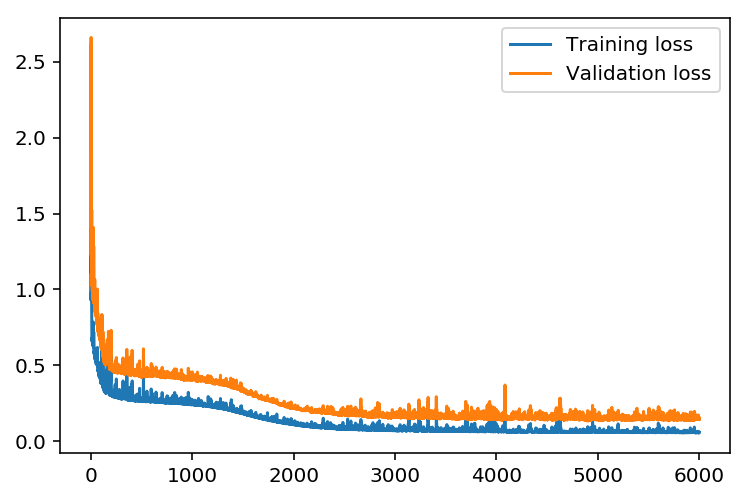

In [19]:
plt.plot(losses['train'], label = 'Training loss')
plt.plot(losses['validation'], label = 'Validation loss')
plt.legend()
_ = plt.ylim()

## 检查预测结果
使用测试数据检查网络对数据建模的效果如何。

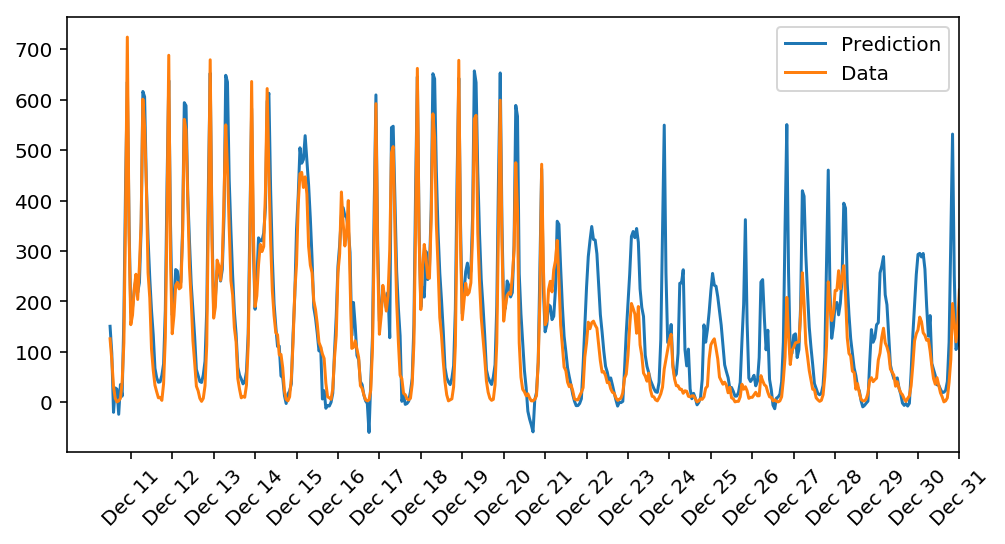

In [20]:
fig, ax = plt.subplots(figsize = (8, 4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T * std + mean
ax.plot(predictions[0], label = 'Prediction')
ax.plot((test_targets['cnt'] * std + mean).values, label = 'Data')
ax.set_xlim(right = len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation = 45)